# BoW model for constructing global image descriptors

In this recipe, you will learn how to apply the **Bag-of-Words (BoW)** model for computing global image descriptors. This technique can be used for building a machine learning model to solve image classification problems.

The Bag-of-Words model works in two phases. In the training phase, one collects local image descriptors for training images (`img0` and `img1`, in our case) and clusters them into vocabulary. In the second phase, local descriptors found in the input image are compared with all vocabulary words, alongside a list of how often each word appeared (for example, was selected as the closest one) within the image, for example, the frequencies vector, which forms the global image descriptor.

### [2.3. Обучение словаря с использованием алгоритма кластеризации K-means](https://www.intuit.ru/studies/courses/10621/1105/lecture/17991?page=3)

Одним из основных подходов к обучению словаря дескрипторов является использование алгоритмов кластеризации, в частности, `K-means`, который разбивает множество объектов на заранее известное число кластеров. В основе данного алгоритма лежит итерационная процедура, в рамках которой вычисляются центроиды кластеров (как математическое ожидание относящихся к данным кластерам объектов), а потом обновляется информация о принадлежности каждого объекта к кластерам путем выбора ближайшего центроида.

Для обучения словаря с использованием алгоритма `K-means` в библиотеке OpenCV реализован класс `BOWKMeansTrainer`, унаследованный от базового абстрактного класса `BOWKMeansTrainer`. Рассмотрим методы данного класса.

```cpp
BOWKMeansTrainer(int clusterCount, 
  const TermCriteria& termcrit = TermCriteria(), 
  int attempts=3, int flags=KMEANS_PP_CENTERS) 
```

Параметры конструктора данного класса соответствуют параметрам функции `kmeans` библиотеки OpenCV.

* `сlusterCount` – число слов в словаре (соответствует числу кластеров в алгоритме `K-means`).
* `termcrit` – критерий остановки алгоритма кластеризации (максимальное число итераций или(и) достижение заданной точности). Точность задается в соответствующем поле `criteria.epsilon`. Если в результате очередной итерации алгоритма центроиды изменились на величину, меньше данного параметра, то алгоритм останавливает работу.
* `attempts` – число запусков алгоритма кластеризации со случайно выбранными центроидами на начальной итерации алгоритма.
* `flags` – параметр, определяющий способ инициализации центроидов на начальной итерации алгоритма. Возможные значения:
   * `KMEANS_RANDOM_CENTERS` – использовать случайно выбранные центроиды.
   * `KMEANS_PP_CENTERS` – использовать эвристику `Arthur` and `Vassilvitskii`. Данный параметр показал лучшую эффективность на практике и используется по умолчанию.



In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep  = pYstep  = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    #print("pXstep", pXstep, "pYstep", pYstep)
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S07\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s07\env

d:\html_doc\program\opencv\packt\s07\env\lib\site-packages
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s07\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S07\env


------  data/people.jpg----------    Shape(425, 640) img_people: uint8
[ 40 25 143 217 204 204 197 203 205 193 195 195 197 192 196 199 193 199 204 203 195 201 197 ]
[ 43 22 147 214 206 190 198 205 203 200 199 201 199 206 195 201 199 205 194 195 196 204 203 ]
[ 46 17 142 230 195 205 198 203 197 198 195 207 210 202 200 207 199 203 194 194 198 192 176 ]
[ 45 17 128 238 196 208 203 203 196 209 193 184 196 191 198 184 194 189 188 193 193 199 203 ]
[ 47 25 48 220 196 188 191 199 197 199 192 184 181 180 196 186 202 186 198 192 179 194 182 ]
------  data/face.jpeg-----------    Shape(700, 1050) img_face: uint8
[ 255 255 240 226 180 171 163 160 158 158 163 169 166 170 167 166 170 166 167 180 193 215 ]
[ 255 255 246 238 202 185 168 160 158 158 161 165 167 169 165 165 170 166 165 177 193 215 ]
[ 255 255 249 245 227 202 175 163 161 162 162 163 168 169 164 164 170 166 165 175 195 215 ]
[ 255 255 250 248 244 214 181 165 164 165 164 163 168 169 163 164 169 166 164 174 196 215 ]
[ 255 255 255 255 248 

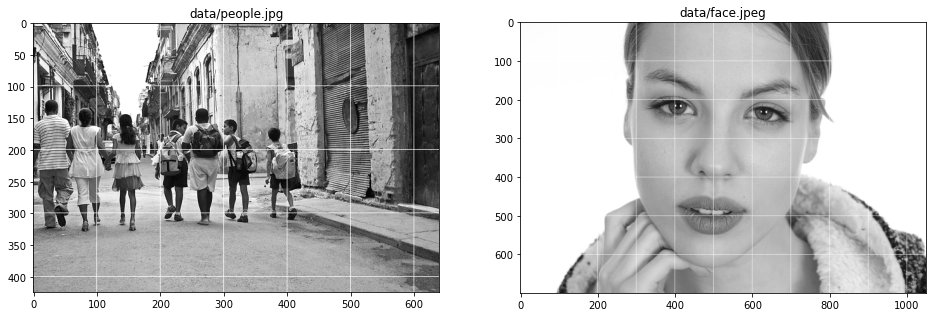

In [21]:
img_people = cv2.imread('../data/people.jpg', cv2.IMREAD_GRAYSCALE)
img_face = cv2.imread('../data/face.jpeg', cv2.IMREAD_GRAYSCALE)




######################################
print_image('data/people.jpg','img_people',img_people,300,305,100,123)
print_image('data/face.jpeg','img_face',img_face,300,305,268,290)
plt_view_image(plt,[["data/people.jpg", draw_grid(np.copy(img_people),100,(255,255,255))],
                    ["data/face.jpeg",  draw_grid(np.copy(img_face),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

Detect the keypoints and computer descriptors for each training image:

------  fea_people---------------    Shape(500, 32) fea_people: uint8
[ 210 144 ]
[ 9 95 ]
[ 105 231 ]
[ 128 172 ]
[ 210 159 ]
[ 9 205 ]
------  fea_face-----------------    Shape(500, 32) fea_face: uint8
[ 61 217 ]
[ 217 77 ]
[ 111 24 ]
[ 43 183 ]
[ 57 242 ]
[ 95 169 ]


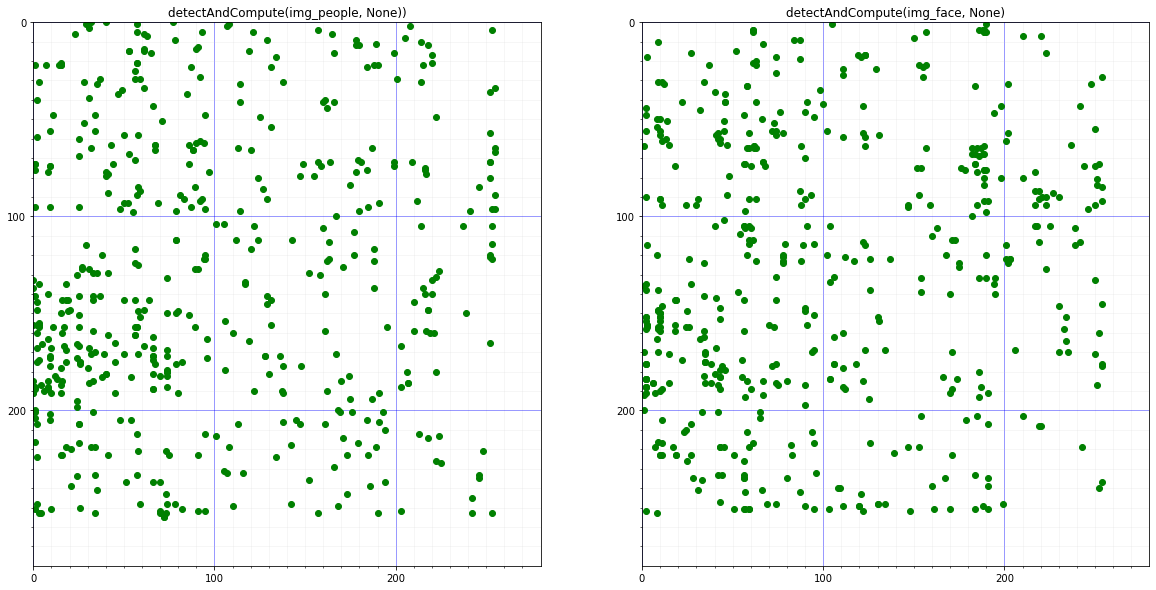

In [34]:
detector = cv2.ORB_create(500)
_, fea_people = detector.detectAndCompute(img_people, None)
_, fea_face = detector.detectAndCompute(img_face, None)

descr_type = fea_people.dtype



#############################################
print_image('fea_people','fea_people',fea_people,0,6,0,2)
print_image('fea_face','fea_face',fea_face,0,6,0,2)

plt.figure(figsize=(20,10))

plt.subplot(121)
plt_view_grid(plt, 'on',(0,280,0,280),(100,10,100,10),major_color='b')
plt.title('detectAndCompute(img_people, None))')
plt.plot(fea_people[:,0],fea_people[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(122)
plt_view_grid(plt, 'on',(0,280,0,280),(100,10,100,10),major_color='b')
plt.title('detectAndCompute(img_face, None)')
plt.plot(fea_face[:,0],fea_face[:,1],'o', color="green")
plt.gca().invert_yaxis()
plt.show()



Construct the BoW vocabulary:

### [2.3. Обучение словаря с использованием алгоритма кластеризации K-means](https://www.intuit.ru/studies/courses/10621/1105/lecture/17991?page=3#sect12)

Одним из основных подходов к обучению словаря дескрипторов является использование алгоритмов кластеризации, в частности, `K-means`, который разбивает множество объектов на заранее известное число кластеров. В основе данного алгоритма лежит итерационная процедура, в рамках которой вычисляются центроиды кластеров (как математическое ожидание относящихся к данным кластерам объектов), а потом обновляется информация о принадлежности каждого объекта к кластерам путем выбора ближайшего центроида.

Для обучения словаря с использованием алгоритма `K-means` в библиотеке OpenCV реализован класс `BOWKMeansTrainer`, унаследованный от базового абстрактного класса `BOWKMeansTrainer`. Рассмотрим методы данного класса.

```cpp
BOWKMeansTrainer(int clusterCount, 
  const TermCriteria& termcrit = TermCriteria(), 
  int attempts=3, int flags=KMEANS_PP_CENTERS) 
```

Параметры конструктора данного класса соответствуют параметрам функции `kmeans` библиотеки OpenCV.

* `сlusterCount` – число слов в словаре (соответствует числу кластеров в алгоритме `K-means`).
* `termcrit` – критерий остановки алгоритма кластеризации (максимальное число итераций или(и) достижение заданной точности). Точность задается в соответствующем поле `criteria.epsilon`. Если в результате очередной итерации алгоритма центроиды изменились на величину, меньше данного параметра, то алгоритм останавливает работу.
* `attempts` – число запусков алгоритма кластеризации со случайно выбранными центроидами на начальной итерации алгоритма.
* `flags` – параметр, определяющий способ инициализации центроидов на начальной итерации алгоритма. Возможные значения:
   * `KMEANS_RANDOM_CENTERS` – использовать случайно выбранные центроиды.
   * `KMEANS_PP_CENTERS` – использовать эвристику `Arthur` and `Vassilvitskii`. Данный параметр показал лучшую эффективность на практике и используется по умолчанию.

Для формирования выборки объектов, на которой будет проходить обучение словаря, должен быть использован метод `add`:

```cpp
void BOWTrainer::add(const Mat& descriptors) 
```

В качестве параметра данной функции передается набор (матрица) дескрипторов особых точек, вычисленных ранее.

После того, как выборка сформирована, обучение словаря выполняется с использованием метода `cluster`.

```cpp
Mat BOWTrainer::cluster() 
```
Данный метод возвращает набор центроидов построенных кластеров, который в дальнейшем используется в качестве словаря дескрипторов особых точек.

Рассмотрим пример функции, которая принимает на вход набор вычисленных дескрипторов особых точек и размер словаря, и возвращает построенный словарь.

------  vocab--------------------    Shape(50, 32) vocab: uint8
[ 36 166 ]
[ 103 167 ]
[ 77 115 ]
[ 85 113 ]
[ 173 98 ]
[ 155 142 ]


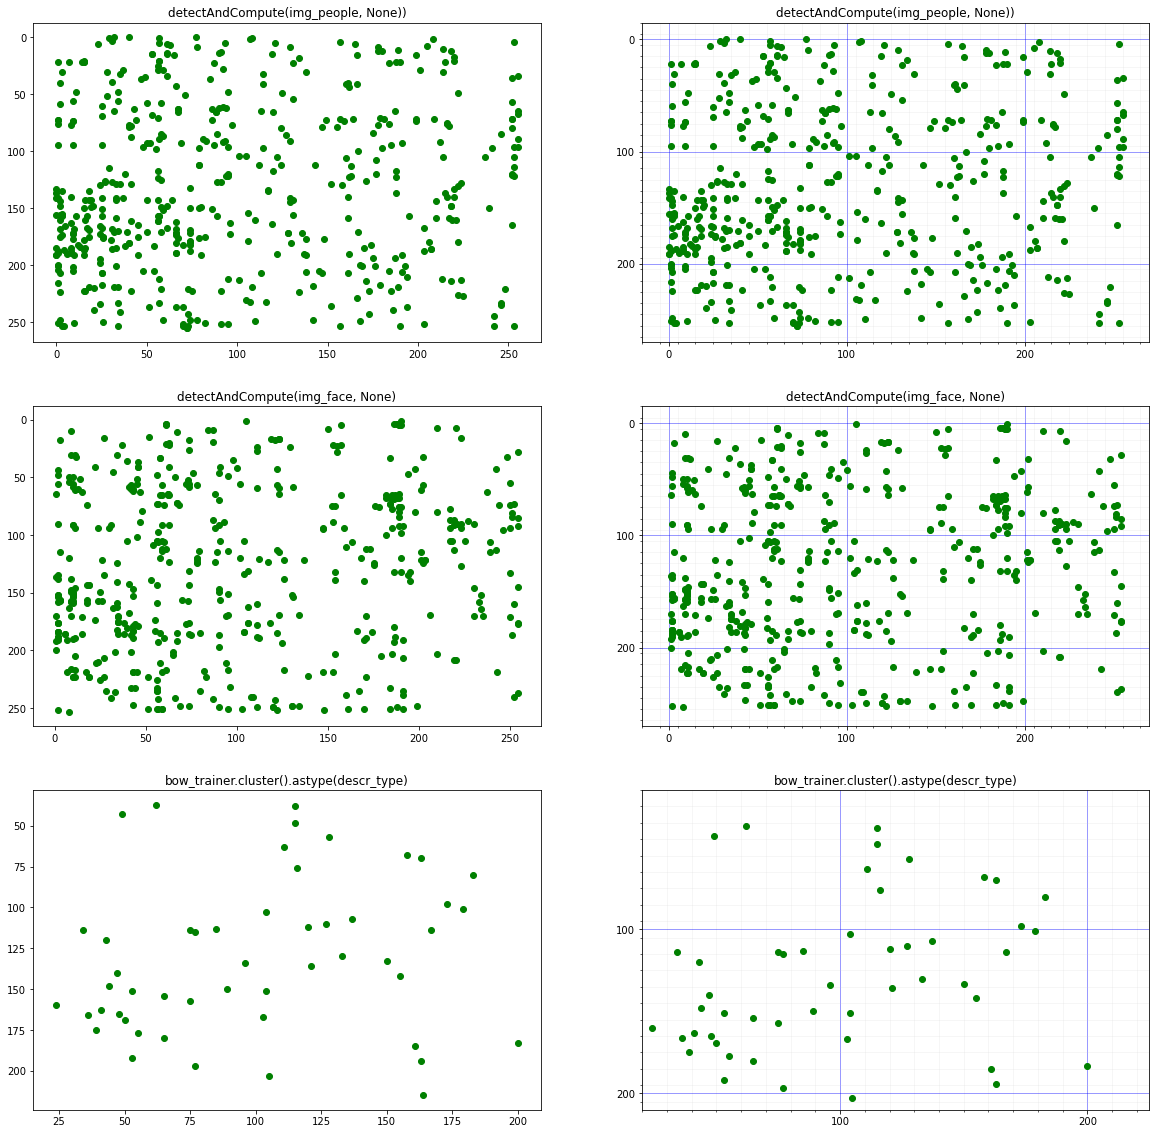

In [59]:
bow_trainer = cv2.BOWKMeansTrainer(50)
bow_trainer.add(np.float32(fea_people))
bow_trainer.add(np.float32(fea_face))
vocab = bow_trainer.cluster().astype(descr_type)




###########################################
print_image('vocab','vocab',vocab,0,6,0,2)

plt.figure(figsize=(20,20))

plt.subplot(321)
#plt_view_grid(plt, 'on',(0,280,0,280),(100,10,100,10),major_color='b')
plt.title('detectAndCompute(img_people, None))')
plt.plot(fea_people[:,0],fea_people[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(322)
plt_view_grid(plt, 'on',(-15,270,-15,270),(100,10,100,10),major_color='b')
plt.title('detectAndCompute(img_people, None))')
plt.plot(fea_people[:,0],fea_people[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(323)
#plt_view_grid(plt, 'on',(0,280,0,280),(100,10,100,10),major_color='b')
plt.title('detectAndCompute(img_face, None)')
plt.plot(fea_face[:,0],fea_face[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(324)
plt_view_grid(plt, 'on',(-15,270,-15,270),(100,10,100,10),major_color='b')
plt.title('detectAndCompute(img_face, None)')
plt.plot(fea_face[:,0],fea_face[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(325)
#plt_view_grid(plt, 'on',(0,280,0,280),(100,10,100,10),major_color='b')
plt.title('bow_trainer.cluster().astype(descr_type)')
plt.plot(vocab[:,0],vocab[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.subplot(326)
plt_view_grid(plt, 'on',(20,225,15,210),(100,10,100,10),major_color='b')
plt.title('bow_trainer.cluster().astype(descr_type)')
plt.plot(vocab[:,0],vocab[:,1],'o', color="green")
plt.gca().invert_yaxis()

plt.show()

Create an object for computing global image BoW descriptors:

### [2.4. Вычисление признаковых описаний изображений](https://www.intuit.ru/studies/courses/10621/1105/lecture/17991?page=3#sect13)

Большинство известных алгоритмов обучения с учителем требует описания каждого объекта в виде векторов одинаковой длины. В связи с этим напрямую использовать вычисленные значения дескрипторов, объединенные в один вектор, для решения задачи классификации не представляется возможным, т.к. в общем случае число ключевых точек на изображениях различно. К тому же, такое представление в любом случае не обладало бы инвариантностью относительно многих преобразований изображения, т.к. при этом обычно изменяется расположение данных точек и, следовательно, расположение дескрипторов внутри объединенного вектора. Данная проблема решается при использовании **bag-of-words** подхода, в котором изображение описывается не самими дескрипторами, а частотами встречаемости их различных типов на изображении. Типы дескрипторов описываются словарем, который содержит центроиды кластеров дескрипторов особых точек. Таким образом, в случае, когда словарь уже вычислен, признаковое описание изображения вычисляется по следующей схеме:

* детектирование ключевых точек на изображении и вычисление их дескрипторов;
* нахождение для каждого вычисленного дескриптора ближайшего к нему центроида кластера;
* вычисление признакового описания изображения в виде нормированной гистограммы (i-ый бин гистограммы соответствует числу вхождений i-го слова из словаря в описание изображения, что соотвествует числу дескрипторов, отнесенных к i-му кластеру).

Библиотека OpenCV содержит класс `BOWImgDescriptorExtractor`, реализующий данную схему. Рассмотрим подробнее методы данного класса.

```cpp
BOWImgDescriptorExtractor::BOWImgDescriptorExtractor( 
      const Ptr<DescriptorExtractor>& dextractor, 
      const Ptr<DescriptorMatcher>& dmatcher) 
```

Рассмотрим параметры конструктора данного класса:

* `dextractor` – алгоритм, вычисляющий дескрипторы в ключевых точках
* `dmatcher` – алгоритм, используемый для нахождения ближайшего центроида к текущему дескриптору ключевой точки (обычно используется $L2$ метрика)

Для того чтобы задать словарь, используемый при вычислении признакового описания изображения, необходимо вызвать метод `setVocabulary`

```cpp
void BOWImgDescriptorExtractor::setVocabulary(const Mat& vocabulary) 
```

В качестве параметра данному методу передается матрица, содержащая центроиды кластеров (обычно это матрица возвращается методом `cluster` класса `BOWTrainer`).

Вычисление признакового описания изображения осуществляется при помощи метода `compute`.

```cpp
void BOWImgDescriptorExtractor::compute(const Mat& image, 
    vector<KeyPoint>& keypoints, 
    Mat& imgDescriptor, 
    vector<vector<int>>* pointIdxsOfClusters=0, 
    Mat* descriptors=0 ) 
```

Рассмотрим параметры данного метода:

* `image` – входное изображение.
* `keypoints` – массив ключевых точек на изображении, в которых вычисляются дескрипторы.
* `imgDescriptor` – вычисленное признаковое описание изображения.
* `pointIdxsOfClusters` – набор индексов дескрипторов, относящихся к тому или иному кластеру.
* `descriptors` – вычисленные значения дескрипторов ключевых точек.

Два последних параметра являются необязательными.

In [5]:
bow_descr = cv2.BOWImgDescriptorExtractor(detector, cv2.BFMatcher(cv2.NORM_HAMMING))
bow_descr.setVocabulary(vocab)

Load the test image, find the keypoints, and the compute global image descriptor:

------  descr_Lena---------------    Shape(1, 50) descr_Lena: float32
[ 0.012 0.020000001 ]


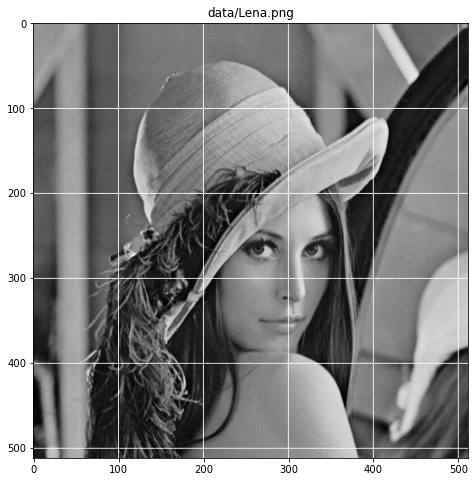

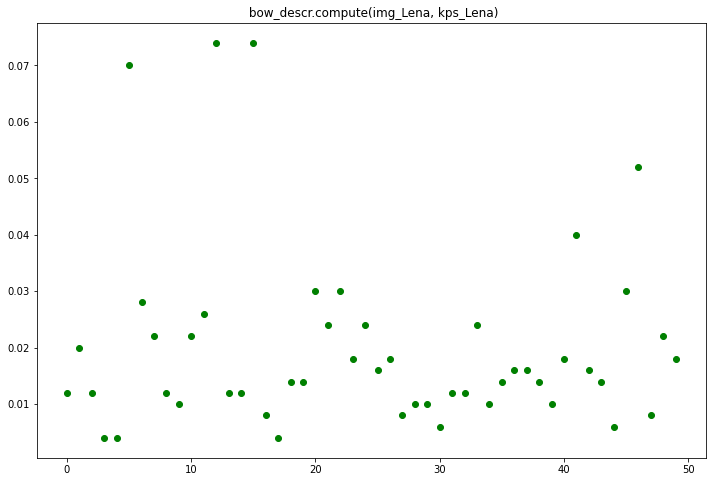

In [69]:
img_Lena = cv2.imread('../data/Lena.png', cv2.IMREAD_GRAYSCALE)
kps_Lena = detector.detect(img_Lena, None)
descr_Lena = bow_descr.compute(img_Lena, kps_Lena)


#########################################################
print_image('descr_Lena','descr_Lena',descr_Lena,0,6,0,2)

plt_view_image(plt,[["data/Lena.png", draw_grid(np.copy(img_Lena),100,(255,255,255))]],
               figsize=(8,8), axis='on', cmap='gray')

plt.figure(figsize=(12,8))
plt.title(' bow_descr.compute(img_Lena, kps_Lena)')
plt.plot(range(0,50),descr_Lena[0],'o', color="green")

plt.show()

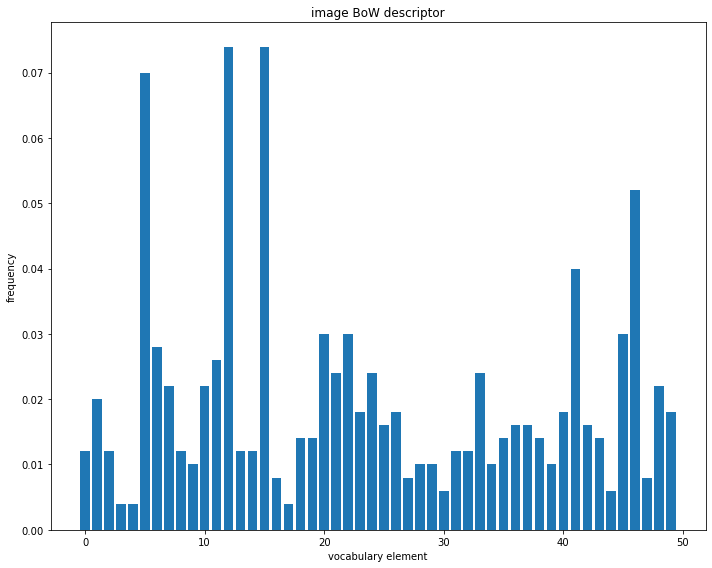

In [7]:
plt.figure(figsize=(10,8))
plt.title('image BoW descriptor')
plt.bar(np.arange(len(descr_Lena[0])), descr_Lena[0])
plt.xlabel('vocabulary element')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()